# Predict `Subject Age`

https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/

In [1]:
%matplotlib inline

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
##### Step 1: import functions #####
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Activation, Conv2D, AveragePooling2D, Input, Softmax, Concatenate
from tensorflow.keras.models import load_model, Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
import pickle
import pandas as pd
import numpy as np
from numpy.random import seed; seed(111)
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.random import set_seed; set_seed(111)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import normalize
from six import StringIO  
from sklearn.tree import export_graphviz, DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from scipy.stats import ttest_ind
from IPython.display import Image  
import time
from pathlib import Path
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer

In [4]:
# %config InlineBackend.figure_format = 'svg'
plt.rcParams['figure.figsize'] = [9,6]

In [5]:
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [6]:
phenotype = 'Subject Age'

In [7]:
#load data
aging_dir = Path('/home/ubuntu/local/aging')

with open(aging_dir/'aging-cytof-data.obj', 'rb') as f:
    allData = pickle.load(f)
samples = allData["samples"]
cyto_data = allData['expr_list']
# Truncate cytodata
cyto_data = cyto_data[ :, :int(5e3)]
markers = allData["marker_names"]

print(f'Dimensions of cyto_data: {cyto_data.shape}')
print(f'Dimensions of samples: {samples.shape}')
print(f'Names of the makers: {markers.values}')

Dimensions of cyto_data: (260, 5000, 27, 1)
Dimensions of samples: (260, 85)
Names of the makers: ['CELL_LENGTH' 'DEAD' 'CD19' 'CD4' 'CD8' 'IGD' 'CD85J' 'CD16' 'CD3' 'CD38'
 'CD27' 'CD14' 'CD94' 'CCR7' 'CD45RA' 'CD20' 'CD127' 'CD33' 'CD28' 'CD24'
 'CD161' 'TCRGD' 'CD56' 'HLADR' 'CD25' 'DNA1' 'DNA2']


In [8]:
samples.columns

Index(['Subject Accession', 'Species', 'Race', 'Race Specify', 'Ethnicity',
       'Strain', 'Gender', 'Age Event', 'Age Event Specify', 'Subject Age',
       'Age Unit', 'Subject Phenotype', 'ARM Accession', 'ARM Name',
       'Study Accession', 'Study Brief Title', 'Biosample Accession',
       'Biosample Description', 'Biosample Name', 'Biosample Type',
       'Biosample Subtype', 'Study Time Collected',
       'Study Time Collected Unit', 'Study Time T0 Event',
       'Study Time T0 Event Specify', 'Biosample Treatment',
       'Planned Visit Accession', 'Planned Visit Name', 'Experiment Accession',
       'Expsample Accession', 'Expsample Description',
       'Expsample Result Schema', 'Expsample Treatement', 'Reagent Accession',
       'Reagent Name', 'Reagent Reporter Name', 'File Info ID', 'File Detail',
       'File Name', 'Original File Name', 'fcs', 'pkl', 'pkl_exists', 'n_rows',
       'n_columns', 'markers', 'WBC', 'RBC', 'Hemoglobin', 'Hematocrit', 'MCV',
       'MCH', 'M

count    260.000000
mean      68.303846
std       15.169696
min       41.000000
25%       55.000000
50%       69.000000
75%       82.000000
max       90.000000
Name: Subject Age, dtype: float64


<AxesSubplot:ylabel='Frequency'>

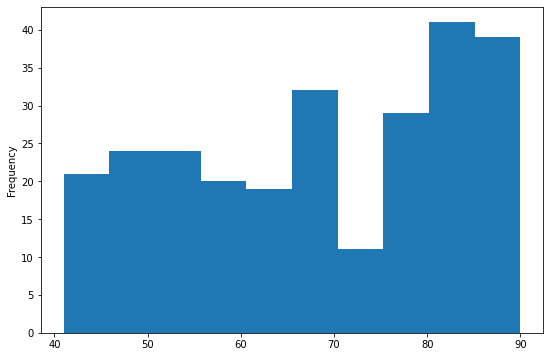

In [9]:
print(samples[phenotype].describe())
samples[phenotype].plot.hist()

In [10]:
blood_start_index = samples.columns.get_indexer(['markers'])[0]+1
blood_df = samples.iloc[:, blood_start_index:]
blood_df.shape

(260, 39)

In [11]:
blood_df = blood_df.dropna(axis=0, how='all')
blood_df = blood_df.dropna(axis=1, thresh=blood_df.shape[0]-10)
blood_df.shape

(202, 37)

In [12]:
null_cols = blood_df.isnull().sum()
null_cols = null_cols[null_cols.gt(0)]
null_cols

NEUT_Pct                  2
LYM_Pct                   2
MONO_Pct                  2
EOS_Pct                   2
BASO_Pct                  5
TotalCholesterol          1
LDLCholesterol            1
Cholesterol_HDLRatio      1
Non-HDLCholesterolcalc    1
LDL_HDLRatio              2
C-ReactiveProtein         1
PlateletCount             2
dtype: int64

In [34]:
def unscale_vec(scaler, x):
    x = np.asarray(x)
    return scaler.inverse_transform(x.reshape(-1,1)).reshape(1,-1)[0]

In [14]:
i_train, i_valid, _, _ = train_test_split(blood_df.index, blood_df.index)

y_train = np.asarray(samples[phenotype].loc[i_train])
y_valid = np.asarray(samples[phenotype].loc[i_valid])
y_scaler = MinMaxScaler()
y_train = y_scaler.fit_transform(y_train.reshape(-1,1)).reshape(1,-1)[0]
y_valid = y_scaler.transform(y_valid.reshape(-1,1)).reshape(1,-1)[0]

blood_train = np.asarray(blood_df.loc[i_train])
blood_valid = np.asarray(blood_df.loc[i_valid])

blood_imputer = SimpleImputer()
blood_train = blood_imputer.fit_transform(blood_train)
blood_valid = blood_imputer.transform(blood_valid)

blood_scaler = StandardScaler()
blood_train = blood_scaler.fit_transform(blood_train)
blood_valid = blood_scaler.transform(blood_valid)

flow_train = np.asarray([cyto_data[i] for i in i_train])
flow_valid = np.asarray([cyto_data[i] for i in i_valid])
print(flow_train.shape, blood_train.shape, y_train.shape)
print(flow_valid.shape, blood_valid.shape, y_valid.shape)

(151, 5000, 27, 1) (151, 37) (151,)
(51, 5000, 27, 1) (51, 37) (51,)


In [15]:
flow_shape = flow_train.shape
blood_shape = blood_train.shape

flow_model = Sequential([
    Input(shape=flow_shape[1:]),
    Conv2D(4, kernel_size = (1, flow_shape[2]), activation=None),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(8, kernel_size = (1,1), activation=None),
    BatchNormalization(),
    Activation('relu'),
    AveragePooling2D(pool_size = (flow_shape[1], 1)),
    Flatten(),
])

blood_model = Sequential([
    Input(shape=blood_shape[1:]),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
])

cat_layer = Concatenate(axis=1)([flow_model.output, blood_model.output])
decider = BatchNormalization()(cat_layer)
decider = Dense(16)(decider)
decider = BatchNormalization()(decider)
decider = Activation('relu')(decider)
decider = Dense(8)(decider)
decider = BatchNormalization()(decider)
decider = Activation('relu')(decider)
decider = Dense(1, activation=None)(decider)

model = Model(inputs=[flow_model.input, blood_model.input], outputs=decider)

model.compile(loss='huber',
              optimizer='adam',
              metrics=['mean_absolute_error',]
             )

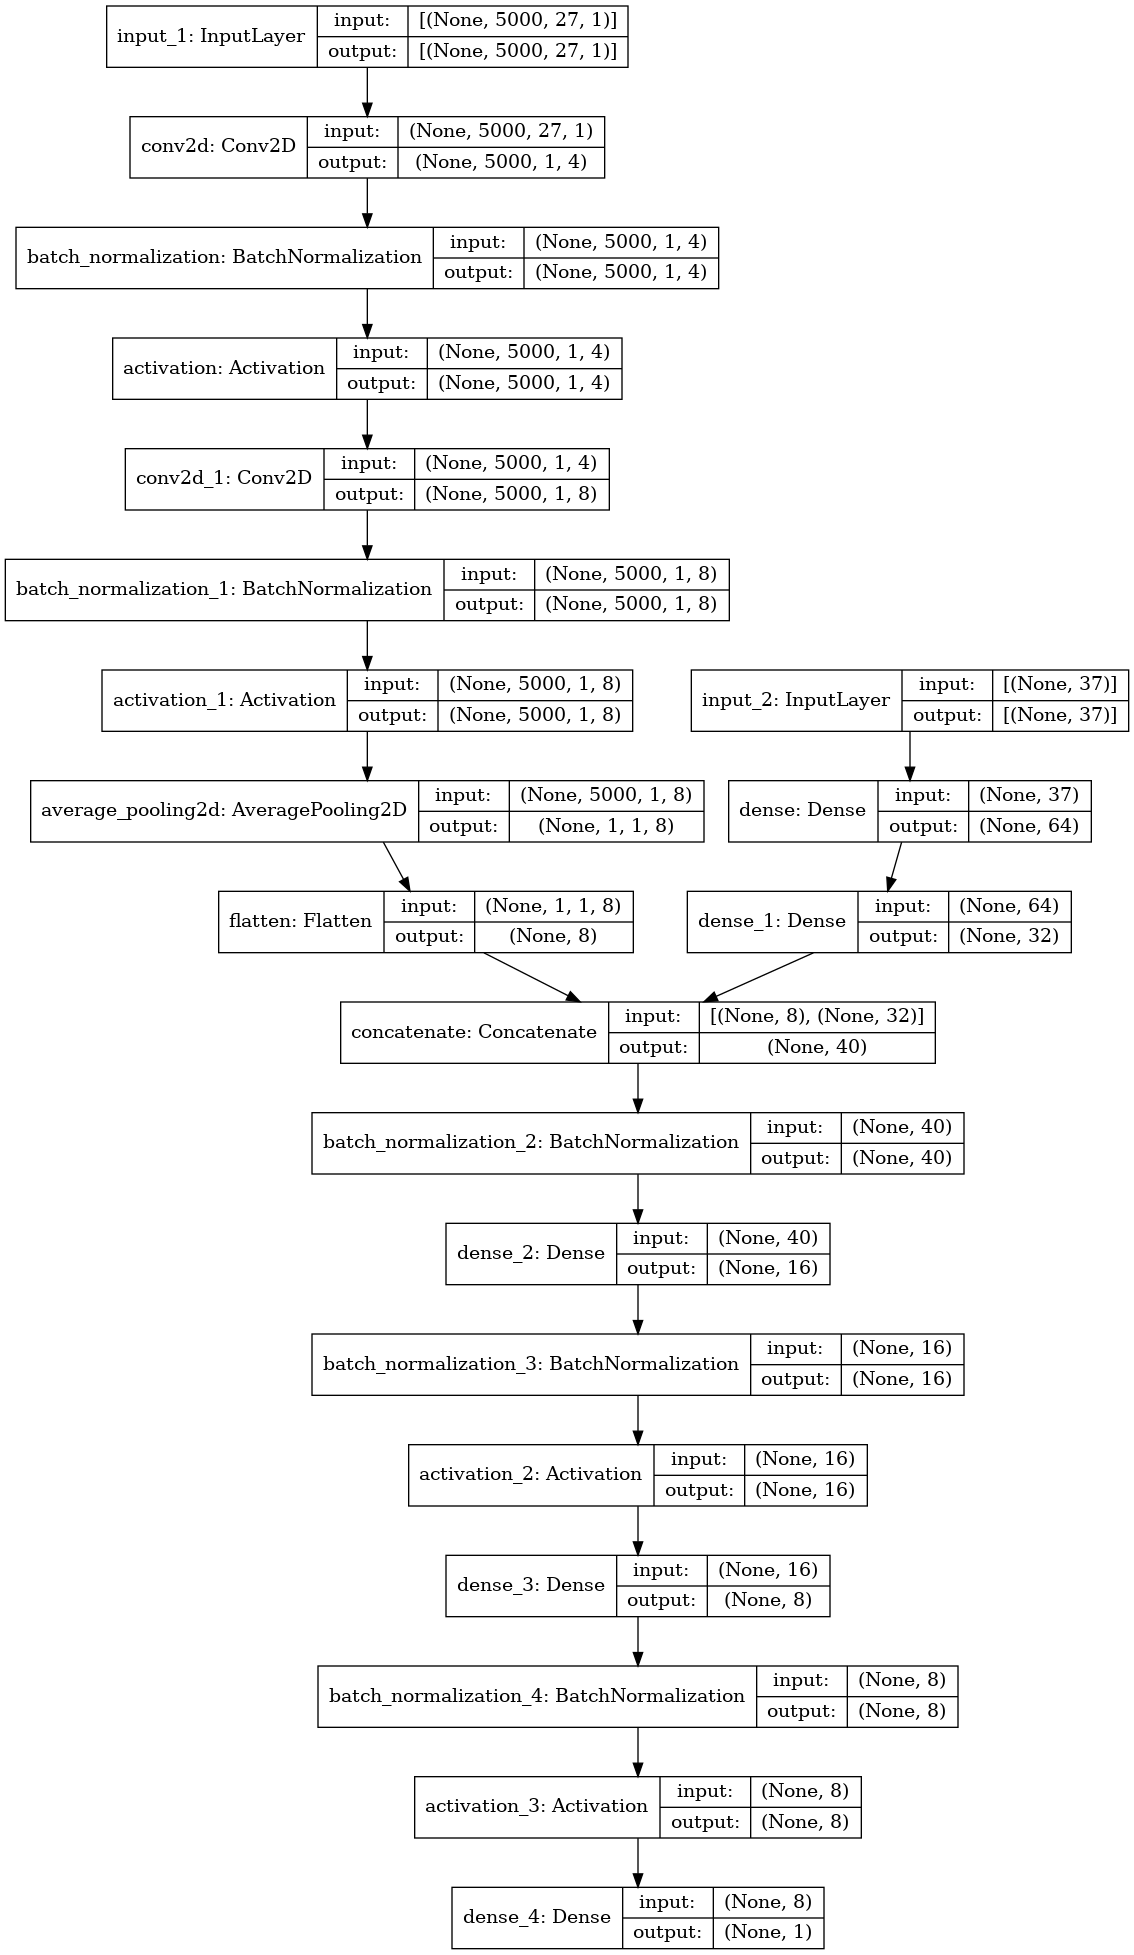

In [16]:
plot_model(model, show_shapes=True)

In [17]:
model.input

[<KerasTensor: shape=(None, 5000, 27, 1) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(None, 37) dtype=float32 (created by layer 'input_2')>]

In [18]:
model.output

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_4')>

In [19]:
%%time
model_store = Path(f'Result/saved_weights_{phenotype}.hdf5')

# save the best performing model
checkpointer = ModelCheckpoint(filepath=model_store, 
                               monitor='val_loss', verbose=0, 
                               save_best_only=True)

st = time.time()
# model training
model.fit([flow_train, blood_train], y_train,
          batch_size=20,
          epochs=200, 
          verbose=1,
          callbacks=[checkpointer],
          validation_data=([flow_valid, blood_valid], y_valid))
rt = time.time()-st

Epoch 1/200
8/8 [==============================] - 4s 53ms/step - loss: 0.2487 - mean_absolute_error: 0.5976 - val_loss: 0.1671 - val_mean_absolute_error: 0.5119
Epoch 2/200
8/8 [==============================] - 0s 14ms/step - loss: 0.1572 - mean_absolute_error: 0.4530 - val_loss: 0.1506 - val_mean_absolute_error: 0.4847
Epoch 3/200
8/8 [==============================] - 0s 13ms/step - loss: 0.1258 - mean_absolute_error: 0.4093 - val_loss: 0.1301 - val_mean_absolute_error: 0.4463
Epoch 4/200
8/8 [==============================] - 0s 14ms/step - loss: 0.1002 - mean_absolute_error: 0.3448 - val_loss: 0.1148 - val_mean_absolute_error: 0.4143
Epoch 5/200
8/8 [==============================] - 0s 13ms/step - loss: 0.0889 - mean_absolute_error: 0.3410 - val_loss: 0.1015 - val_mean_absolute_error: 0.3830
Epoch 6/200
8/8 [==============================] - 0s 12ms/step - loss: 0.0771 - mean_absolute_error: 0.3154 - val_loss: 0.0962 - val_mean_absolute_error: 0.3703
Epoch 7/200
8/8 [===========

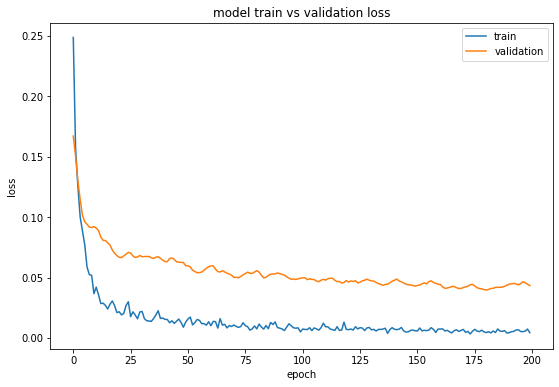

In [26]:
##### Step 6: plot train and validation loss #####
history = model.history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

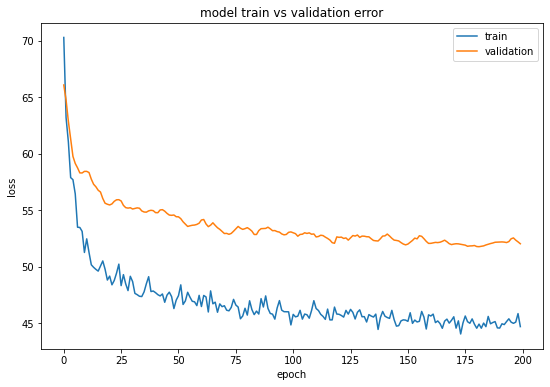

In [35]:
##### Step 6: plot train and validation loss #####
plt.plot(unscale_vec(y_scaler, history.history['mean_absolute_error']))
plt.plot(unscale_vec(y_scaler, history.history['val_mean_absolute_error']))
plt.title('model train vs validation error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()


In [22]:
#### Step 7: test the final model #####
final_model = load_model(model_store)
y_scores = final_model.predict([flow_valid, blood_valid])
y_scores = y_scores.reshape(y_scores.shape[0])
vals_true = pd.Series(y_scaler.inverse_transform(y_valid.reshape(-1,1)).reshape(1,-1)[0])
vals_pred = pd.Series(y_scaler.inverse_transform(y_scores.reshape(-1,1)).reshape(1,-1)[0])
errors = vals_pred - vals_true
errors.describe()

count    51.000000
mean      0.784348
std      13.912191
min     -27.051514
25%      -7.006542
50%      -2.345219
75%       7.940781
max      34.948410
dtype: float64

[ 0.39436753 41.20734615]


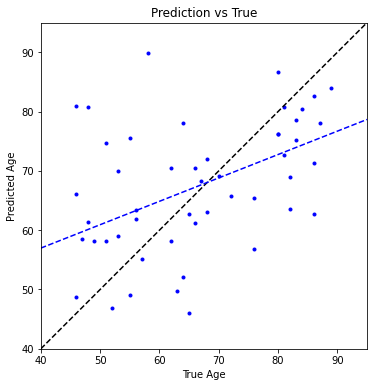

In [23]:
plt.plot(vals_true, vals_pred,'b.')
plt.axis('square')
plt.xlim((40,95))
plt.ylim((40,95))
plt.xlabel('True Age')
plt.ylabel('Predicted Age')
plt.title('Prediction vs True')
plt.plot([40,95],[40,95],'--k')
coef = np.polyfit(vals_true, vals_pred, 1)
print(coef)
poly1d_fn = np.poly1d(coef)
plt.plot([40,95], poly1d_fn([40,95]), '--b')
plt.show()

count    51.000000
mean      0.784348
std      13.912191
min     -27.051514
25%      -7.006542
50%      -2.345219
75%       7.940781
max      34.948410
dtype: float64


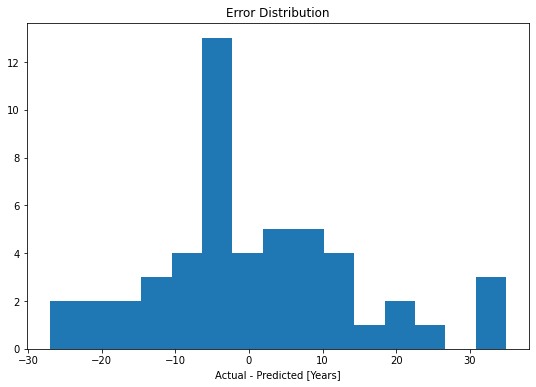

In [24]:
print(errors.describe())
plt.hist(errors, bins=int((errors.max()-errors.min())/4))
plt.title('Error Distribution')
plt.xlabel('Actual - Predicted [Years]')
plt.show()

count    51.000000
mean     10.801447
std       8.670172
min       0.247269
25%       4.384415
50%       7.812195
75%      14.408581
max      34.948410
dtype: float64


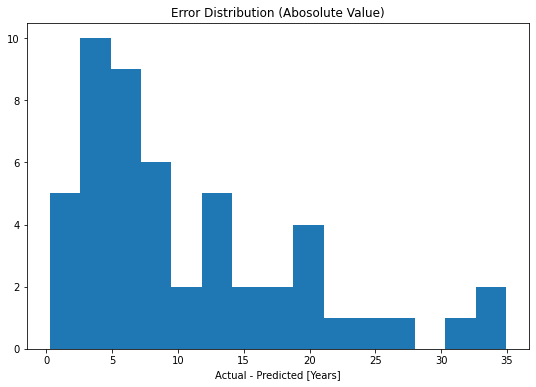

In [25]:
print(errors.abs().describe())
plt.hist(errors.abs(), bins=int((errors.max()-errors.min())/4))
plt.title('Error Distribution (Abosolute Value)')
plt.xlabel('Actual - Predicted [Years]')
plt.show()